# Gaussian Process Regression

## Set up environment

In [1]:
%reset -f

import matplotlib.pyplot as plt

#matplotlib graphs will be included in your notebook, next to the code:
%matplotlib inline

import torch
import gpytorch

## Generate Data (1D)
We are going to look at some data generated by random sampling in the domain [0,10].
The function that generated this data is

$$
f(x) = \sin(2\pi x) + x
$$

Note the shape of the input tensors. All training data must be at least 2D,
(n_samples, n_dims).

In [2]:
train_x = torch.rand(5,1)*10.0
train_y = 100.0*(torch.sin(2*3.14*train_x/5.0) + train_x)

print(train_x.shape)

torch.Size([5, 1])


Here we initialize our model with the training data and a defined likelihood (also a
nn.Module) with a trainable noise parameter. It is always good practice to normalize
the input data to the domain [0,1]^d and standardize the output/outcome data to have
a mean of zero and a variance of 1.

In [3]:
from botorch.models import SingleTaskGP
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize
model = SingleTaskGP(train_x, train_y, input_transform=Normalize(1),
                     outcome_transform=Standardize(1))


## Examine model hyperparameters
Note that these values are `raw` meaning that they exist in the entire real domain.
`Real` parameters are constrained (like noise, lenthscale > 0). See https://docs
.gpytorch.ai/en/stable/examples/00_Basic_Usage/Hyperparameters.html for details.

In [10]:
# examine raw parameter values
for name, val in model.named_parameters():
    print(f"{name}:{val.item()}")

# get real parameter value for lengthscale
print(f"real lengthscale: {model.covar_module.base_kernel.lengthscale.item()}")

likelihood.noise_covar.raw_noise:9.999999747378752e-05
mean_module.raw_constant:-0.2826169431209564
covar_module.raw_outputscale:2.390821695327759
covar_module.base_kernel.raw_lengthscale:-0.8055465221405029
real lengthscale: 0.36938440799713135


## Training the model
Here we train the hyperparameters of the model (the parameters of the covar_module
and the mean_module) to maximize the marginal log likelihood (minimize the negative
marginal log likelihood). Note that since everything is defined in pyTorch we can use
 Autograd functionality to get the derivatives which will speed up optimization using
  `fit_gpytorch_mll` which internally uses scipy L-BFGS with gradients as the
  optimization algorithm.

In [11]:
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll);

## Plot the 1D model probability distribution

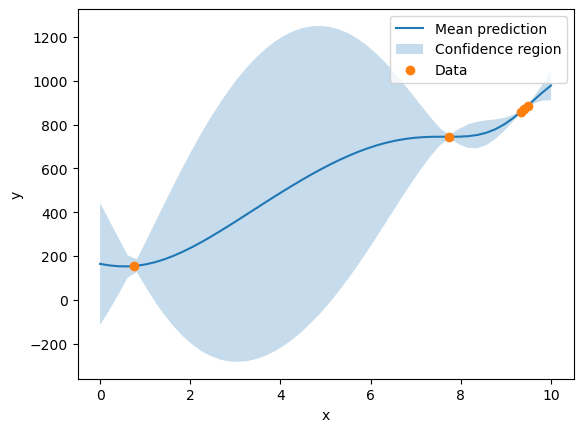

In [12]:
#plot the gp distribution in the normalized range
x = torch.linspace(0, 10, 50)
with torch.no_grad():
    # get the posterior distribution note the input shape
    p = model.posterior(x.unsqueeze(-1))
    
    #get the mean
    m = p.mean
    
    #get the 2 sigma confidence region around the mean
    l,u = p.mvn.confidence_region()

fig,ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('y')
#plot mean and confidence region
ax.plot(x, m, label="Mean prediction")
ax.fill_between(x.squeeze(), l, u, alpha = 0.25, lw = 0, label="Confidence region")

#plot samples
ax.plot(train_x, train_y,'oC1',label="Data")
ax.legend()

## Reexamine model hyperparameters after training

In [13]:
# examine raw parameter values
for name, val in model.named_parameters():
    print(f"{name}:{val.item()}")

# get real parameter value for lengthscale
print(model.covar_module.base_kernel.lengthscale.item())

likelihood.noise_covar.raw_noise:9.999999747378752e-05
mean_module.raw_constant:-0.2826169431209564
covar_module.raw_outputscale:2.390821695327759
covar_module.base_kernel.raw_lengthscale:-0.8055465221405029
0.36938440799713135
